# Ch. 16 - Yolo object localization

In the last chapters, we have mainly considered image classification. Image classification takes an image and assigns a certain label to an image. However, it does not answer _where_ in the image certain things are. Take this image as an example:

![Dog](./assets/dog.jpg)

In this image, we see a dog, a bike, a car and a motorcycle in the back. While a multi class image classifier might tell us that these objects are in the image, it would fail to let us know that the dog and the bike are in the center of the image and that the dog is next to the bike. In this chapter we will give the task of image localization a look. We will also learn about the YOLO9000 architecture, a state of the art architecture for this task. We will furthermore take a practical look at how to construct a more advanced model and a custom graph.

## The big picture
There is a lot more information in an image than just which objects are visible in an image. Humans do not classify images, the immediately interpret them. Take a look at that image again. The scene seems to be at the front porch of a house. The dog is next to the bike and is looking at the photographer. It seems as the dog wants to go for a run while its owner goes for a bike ride. The motorcycle and the car seem to belong to a parking lot and do not matter very much in this scene.

Human interpretation of images happens automatically and is mostly subconscious. It is a process that all humans do without thinking and that heavily relies on heuristics. Not only are we able to recognize the objects based on heuristics, we are also able to approximate their position in space based on our knowledge of the size of items and we can interpret the intention of the dog based on our knowledge of dogs.

Computers can not interpret images like this yet. But researchers have been busy creating systems that can accomplish different parts of the interpretation process. One part is object localization. Other pieces of the puzzle can be emotion classification or spatial location estimation.

## YOLO9000: Better, Faster, Stronger

[YOLO9000](https://arxiv.org/abs/1612.08242) (Redmon and Farhadi, 2016) or Yolo v2 is a state of the art object localization system. Relying on a fully convolutional neural network it is faster and more accurate than previous systems. 

In [1]:
from IPython.display import HTML
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/VOC3huqHrss?rel=0" frameborder="0" gesture="media" allow="encrypted-media" allowfullscreen></iframe>')

## Whats in a name anyway?
YOLO stands for You Only Look Once. Other object localizers usually repurposed image classifiers. They would slide the classifier over an image, and selecting the areas with the highest confidence as the location of the object. This is slow however. So the YOLO architecture aims to take in an image input and directly spit out the locations, only looking once.

![Yolo flow](./assets/model2.png)

YOLO works in multiple steps. We will now walk through them and build an object localizer using YOLO.

**Important Note** In this chapter, we will build the computational graph of the yolo system just as it would be implemented in TensorFlow. However, we will not actually build the graph in TensorFlow, but work with numpy matrices instead. TensorFlow graphs are static: first have to define them before we can run the model. This means we can not inspect the tensors before having built the entire graph or while running the model. Numpy matrices can be printed in python just like any variable but TensorFlow tensors can not be easily inspected. For educational purposes, it is easier to work with numpy matrices. This text will refer to the numpy matrices as tensors and to the entire construct that we build as a computational graph, although there is not actual underlying computational graph built here. The numpy and TensorFlow API are very similar. In most cases you could simply replace ``np.``with ``tf.`` So keep in mind this little inaccuracy we are doing for educational purposes here: We talk of a computational graph, although no actual computational graph is built.

In [2]:
# As always, imports first
import os # For file loading

import numpy as np # For matrices
from keras.models import load_model # Load keras models from h5 files
from PIL import Image, ImageDraw, ImageFont # Image library

import matplotlib.pyplot as plt # For rendering
import matplotlib # For setting render settings
# Instant output
%matplotlib inline 
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0) # Bigger charts

# This little function allows us to render the bounding boxes
from yolo_utils.draw_boxes import draw_boxes

Using TensorFlow backend.
Couldn't import dot_parser, loading of dot files will not be possible.


## The model
The heart of YOLO is a neural network. We work with a pretrained model here. The weights where downloaded from the [author's webpage](https://pjreddie.com/darknet/yolo/). The original Yolo v2 implementation is written in a custom neural network library called DarkNet. This model has been converted to a Keras model using [Allen Zelener's YAD2K converter](https://github.com/allanzelener/YAD2K). Let's take a look at it:

In [3]:
model_path = 'model_data/yolo.h5'
# load keras model
yolo_model = load_model(model_path)

/Users/jannes/anaconda/lib/python3.5/site-packages/keras/models.py:251: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [4]:
yolo_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 608, 608, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 608, 608, 32)  864         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 608, 608, 32)  128         conv2d_1[0][0]                   
____________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)        (None, 608, 608, 32)  0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

While reading the model summary, notice a few things: 

- It is a fully convolutional network. There are no densely connected layers, which makes it faster than previous versions, because convolutional layers have less parameters.

- It uses a Leaky ReLu activation function. Leaky ReLu is very similar ReLu but it allows for a small slope in the negative area. This can improve learning as neurons with negative activations still have a small gradient and get changed.

![Leaky ReLu](./assets/leaky_relu.png)

- The output is a higher dimensional tensor with the dimensions (None, 19, 19, 425). The None is a placeholder for the batch size. If we process only one image the output will be (1, 19, 19, 425). We will dive in the reasoning behind these dimensions in a bit.

- The output has no activation function. We will soon see that the activation function is part of the graph we have yet to build.

But without much further ado, let's run an image through the model!

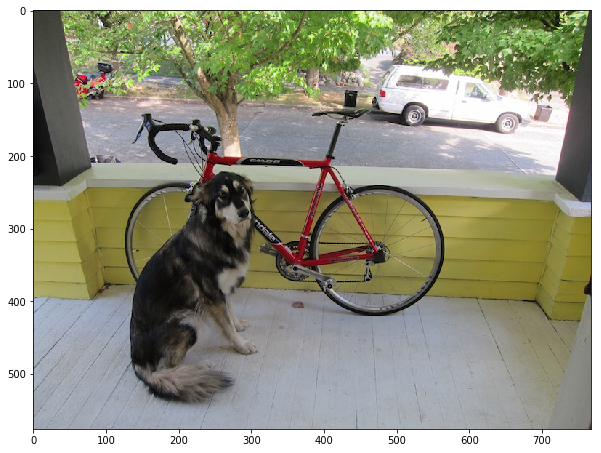

In [5]:
# Get image
image_file = 'assets/dog.jpg'
image = Image.open(image_file)
plt.imshow(image)

In [6]:
# We have to resize the image before we can feed it into the model
print('resizing for fixed size input')
# Get expected input size
model_image_size = yolo_model.layers[0].input_shape[1:3]
# Resize
resized_image = image.resize(
    tuple(reversed(model_image_size)), Image.BICUBIC)
# Turn to np array
image_data = np.array(resized_image, dtype='float32')

resizing for fixed size input


In [7]:
# We also have to scale the image, turning all values from 0 to 255 into values between 0 and 1
image_data /= 255.
print(image_data.shape)

(608, 608, 3)


You can see we have resized our image to 608 by 608 pixels. It has 3 color channels. We now have to add a batch dimension:

In [8]:
image_data = np.expand_dims(image_data, 0)  # Add batch dimension.
print(image_data.shape)

(1, 608, 608, 3)


In [9]:
# Run prediction through model
keras_model_out = yolo_model.predict(image_data)

In [10]:
keras_model_out.shape

(1, 19, 19, 425)

Let's take a closer look at the output of our model. YOLO sees an image as a grid of 19 by 19 cells. This explains the first three dimensions:

|Dimension|Name|Value|Description|
|---------|----|-----|-----------|
|0|Batch size|1|Number of images in batch|
|1|Grid Height|19|Number of rows in grid|
|2|Grid Width|19|Number of columns in grid|
|3|Box features|425|Features of 5 boxes per cell|


![Anon](./assets/model_an.png)

## Anchor boxes
So we have a 19 by 19 grid of cells for which we predict 5 boxes each. But why 5? Researchers have found that they can build much more accuracte models if they give the neural net some tips. They figured out in which positions objects in images usually are and provided these coordinates as anchor boxes. In the image below you can see the anchor boxes YOLO uses (in blue, image from the YOLO9000 paper). They where obtained by [k-means clustering](https://en.wikipedia.org/wiki/K-means_clustering) and are compared to the manually selected boxes researchers used before in grey:

![Anchor Boxes](./assets/anchor_boxes.png)

We do not give the network the positions of all the boxes. We only give it the _dimensions_, height and width. This is why the anchor boxes are also sometimes called 'dimension priors'. Good priors can make learning easier and in this case, providing some common dimensions greatly improves performance. The anchor boxes are saved in a text file we can load:

In [11]:
anchors_path = 'model_data/yolo_anchors.txt'

# Get anchors
with open(anchors_path) as f:
    anchors = f.readline() # Read from file
    anchors = [float(x) for x in anchors.split(',')] # Split text by commas
    anchors = np.array(anchors).reshape(-1, 2) # Turn to numpy array

num_anchors = len(anchors)
print('Number of anchors:',num_anchors)
print(anchors)

Number of anchors: 5
[[ 0.57273   0.677385]
 [ 1.87446   2.06253 ]
 [ 3.33843   5.47434 ]
 [ 7.88282   3.52778 ]
 [ 9.77052   9.16828 ]]


You can see that each box comes with two measurements: height and width. YOLO generally takes the height as the first dimension. Each cell then predicts the coordinates and a transformation of each anchor cell relative to its own position. So for each of the 5 boxes we have 4 location predictors:

|Name|Symbol|Description|
|----|------|-----------|
|Center X|$p_x$|X coordinate of box center relative to predicting cell|
|Center Y|$p_y$|Y coordinate of box center relative to predicting cell|
|Height Multiplier|$p_h$|Multiple of the anchor box height|
|Width Multiplyer|$p_w$|Multiple of the anchor box height|

## Prediction classes (Whats in the Box?)
Now that we know how to predict _where_ the five boxes are, we can move on to figuring out what is actually in the box. This task is very similar to image classification. We have a set of classes and via multiclass prediction we predict which object is most likely in the box. The names of the classes are also stored in a text file:

In [12]:
classes_path = 'model_data/coco_classes.txt'

# Get classes
with open(classes_path) as f:
    class_names = f.readlines() # read file

# Turn classes into array
class_names = [c.strip() for c in class_names]
num_classes = len(class_names) # Get number of classes
print('Number of classes:',num_classes)
print(class_names)

Number of classes: 80
['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


This pretrained version of Yolo we are using comes with 80 classes, ranging from 'banana' to 'aeroplane'. For each box we have a the probabilities of each class being in there. Additionally, we have an output indicating whether _any_ of the classes is present in the box:

|Output per box|
|--------------|
|Center X|
|Center Y|
|Height multiplier|
|Width multiplier|
|Is any item present?|
|80 Class probabilities|

We can reshape our model output to have these 85 numbers per box:

In [13]:
keras_model_out = np.reshape(
        keras_model_out, [-1, # Keep batch unchanged (at 1)
                19, # Number grid cells height
                19, # Number grid cells width
                num_anchors, # Number of anchors
                num_classes + 5]) # box x , box y, box height, box width, any object?,all 80 Classes

# We obtain:
#(batch, grid cell hight, grid cell width, num anchors, positions per box + is anything in the box + classes)
print(keras_model_out.shape)

(1, 19, 19, 5, 85)


## Activation functions
Now we have 19 by 19 grid cells with 5 boxes each for which we have 85 outputs each. These 85 outputs are still the raw output tensors of our model. They have not yet run through an activation function. The reason we have not run them all through an activation function is because they have different activation functions. For the 80 classes we want to use softmax, since this is a multiclass classification problem. But for the location and overall confidence we do not want to use the same softmax, since the location has nothing to do with the classes. So we need to split up the output and run it through different activation functions. Here are the activations we will use:

|Output per box|Activation|
|--------------|-|
|Center X|Sigmoid|
|Center Y|Sigmoid|
|Height multiplier|Exponential|
|Width multiplier|Exponential|
|Is any item present?|Sigmoid|
|80 Class probabilities|Softmax|

An exponential activation means that we will take the exponent of the output. In case you no longer remember the sigmoid and softmax activations, go back to week 1 to give them a look. They are implemented below:

In [14]:
def softmax(z):
    '''
    Calculates the softmax activation of a given input x
    See: https://en.wikipedia.org/wiki/Softmax_function
    '''
    #Calculate exponent term first
    exp_scores = np.exp(z)
    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

In [15]:
def sigmoid(x): 
    return 1/(1+np.exp(-x))

Let's start with the box center. We splice out the x y cordinates of the centers of all the predicted boxes. Then we run them through the activation function.

In [16]:
# Get xy from output
raw_box_xy = keras_model_out[..., :2]
# Run through sigmoid
box_xy = sigmoid(raw_box_xy)

We now have the x y coordinates of all 5 boxes for all 19 by 19 grid cells:

In [17]:
# We obtain (batch, grid cell hight, grid cell width, num anchors, xy)
box_xy.shape

(1, 19, 19, 5, 2)

We can play the same game with the width and height coordinates, only that we take the exponent instead of the sigmoid function of them:

In [18]:
# Get width and hight outputs
raw_box_wh = keras_model_out[..., 2:4]
# Run through the activation function
box_wh = np.exp(raw_box_wh)

In [19]:
# We obtain (batch, grid cell hight, grid cell width, num anchors, wh)
box_wh.shape

(1, 19, 19, 5, 2)

The overall confidence that _anything_ interesting is in the box is run through a sigmoid activation as well:

In [20]:
# Get confidence that there is anything in the box
raw_box_confidence = keras_model_out[..., 4:5]
# Run through activation function
box_confidence = sigmoid(raw_box_confidence)

In [21]:
# We obtain (batch, grid cell hight, grid cell width, num anchors, confidence)
box_confidence.shape

(1, 19, 19, 5, 1)

What remains are the outputs for the 80 classes. We run these through a softmax classifier.

In [22]:
# Get raw outputs for class scores
raw_box_class = keras_model_out[..., 5:]
box_class_probs = softmax(raw_box_class)

In [23]:
# We obtain (batch, grid cell hight, grid cell width, num anchors, probability for each class)
box_class_probs.shape

(1, 19, 19, 5, 80)

## From grid to total image
Now we have 5 boxes per grid cell, each with center coordinates, height, width, an overall confidence and probabilities for each of the 80 classes. The center coordinates however are still in relation to the grid cells that predicted them and the height and width are still multiples of the anchor dimensions. We will now convert the relative postitons and dimensions into absolute positions and dimensions. 

In [24]:
grid_height = 19
grid_width = 19

# Create a list indexing the grid vertically (0,1,2,3...)
grid_height_index = np.arange(0, stop=grid_height)
# Create a list indexing the grind horizontally (0,1,2,3...)
grid_width_index = np.arange(0, stop=grid_width)

# Repeat the height index over the entire width of the image
grid_height_index = np.tile(grid_height_index, [grid_width])

# Repeat the width index over the entire height of the image
grid_width_index = np.tile(np.expand_dims(grid_width_index, 0), [grid_height, 1])

# Flatten the width into one single list
grid_width_index = np.ravel(np.transpose(grid_width_index))

# Stack width and height indices on top of each other
grid_index = np.transpose(np.stack([grid_height_index, grid_width_index]))

# Reshape indices so we obtain a matrix with the same dimensions as the coordinate matrices
grid_index = np.reshape(grid_index, [1, grid_height, grid_width, 1, 2])

# Turn everything into floats to divide easier
grid_index = grid_index.astype(float)

# Create a grid dimension tensor we can divide through
grid_dimensions = np.reshape((grid_height,grid_width), [1, 1, 1, 1, 2]).astype(float)

We now have obtained a matrix indexing the relative position of the grid cells.

In [25]:
grid_index[0,:,:,0,0]

array([[  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.],
       [  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.],
       [  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.],
       [  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.],
       [  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.],
       [  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.],
       [  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.],
       [  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         

We can now add the indices to the x y coordinates and, voila, we have the position of the center coordinates, relative to the entire image.

In [26]:
# Adjust xy position for spatial position in entire image
box_xy = (box_xy + grid_index) / 19

In [27]:
# Dimensions stay the same
box_xy.shape

(1, 19, 19, 5, 2)

We can turn the anchor dimensions into an tensor we can work with and multiply our predicted transformation to obtain relative dimensions of the boxes:

In [28]:
# Get anchors in right shape
anchors_tensor = np.reshape(np.array(anchors), [1, 1, 1, num_anchors, 2])

In [29]:
# Adjust width and height for spatial position in entire image
# 19 = grid dimensionality
box_wh = box_wh * anchors_tensor / 19

In [30]:
# Dimensions stay the same
box_wh.shape

(1, 19, 19, 5, 2)

Now we only have to convert the boxes from center coordinates and dimensions to boxes defined by top left and bottom right corners

In [31]:
"""Convert YOLO box predictions to bounding box corners."""
box_mins = box_xy - (box_wh / 2.)
box_maxes = box_xy + (box_wh / 2.)

cornered_boxes = np.concatenate([
    box_mins[..., 1:2],  # y_min
    box_mins[..., 0:1],  # x_min
    box_maxes[..., 1:2],  # y_max
    box_maxes[..., 0:1]  # x_max
], axis=-1)

In [32]:
# We obtain (batch, grid cell hight, grid cell width, num anchors, box corners)
cornered_boxes.shape

(1, 19, 19, 5, 4)

## Filtering by score threshold
We now have proper coordinates for all of our boxes. But we still have way too many of them. 19 by 19 by 5 = 1805 predictions to be exact. If we, just for fun, rendered all of these predictions it would look something like this:
![Zero Cut](./assets/zero_cut.png)

As you can see, there is multiple cows, sinks, sandwiches and donuts. For most of these, our model has zero confidence of them actually being there. We need to filter out all the predictions which are really poor. We do this by creating an overall score of a prediction. Which is the probability that anything is in the box times the probability of the specific class predictions.

In [33]:
# Box score = probability that anything is in the box * probability a specific class is in the box
box_scores = box_confidence * box_class_probs

# We obtain (batch, grid cell hight, grid cell width, num anchors, score for each class)
print(box_scores.shape)

(1, 19, 19, 5, 80)


In [34]:
# Get the most likely class for each box
box_classes = np.argmax(box_scores, axis=-1)

# We obtain (batch, grid cell hight, grid cell width, most likely class for each anchor)
print(box_classes.shape)

(1, 19, 19, 5)


In [35]:
# Get the score for the most likely class
box_class_scores = np.max(box_scores, axis=-1)

# We obtain (batch, grid cell hight, grid cell width, confidence of most likely class for each anchor)
print(box_class_scores.shape)

(1, 19, 19, 5)


We can now remove all the boxes whose best class has a score below a certain cutoff point.

In [36]:
score_threshold = 0.15
# Get the mask to filter out everything less likely than our threshold
prediction_mask = box_class_scores >= score_threshold

In [37]:
# We obtain (batch, grid cell hight, grid cell width, is better than threshold?)
print(prediction_mask.shape)

(1, 19, 19, 5)


In [38]:
# Filter boxes by whether they exceed threshold
boxes = cornered_boxes[prediction_mask]

In [39]:
# We obtain (found items, bounding box corners)
boxes.shape

(12, 4)

In [40]:
# Filter scores by passing threshold
scores = box_class_scores[prediction_mask]

In [41]:
# Filter classes by score passing threshold
classes = box_classes[prediction_mask]

We are left with only 12 predictions on which the model is more confident than our threshold requires. We will still have to cut some of those, but through a different method we will look at in a bit.

## Scaling boxes
All boxes are still relative to the image, meaning that all coordinates and dimensions lie between 0 and 1. We now have to scale them to the actual image size.

In [42]:
# Get height and width of original image
height = image.height
width = image.width
print('Height:',height,'Width:',width)

Height: 576 Width: 768


In [43]:
# Create image dimension array that can be multiplied with box coordinates
# We store height and width twice to multiply with the upper and lower corner of the box
image_dims = np.stack([height, width, height, width])
image_dims = np.reshape(image_dims, [1, 4])

In [44]:
# We obtain (batch, height & width twice)
image_dims.shape

(1, 4)

In [45]:
# Scale to image
boxes = boxes * image_dims

## Draw the frames
We can now draw the predictions using a helper method:

In [46]:
im_w_boxes = draw_boxes(image=image.copy(),
                        boxes=boxes, 
                        box_classes=classes, 
                        class_names=class_names,
                        scores=scores)

motorbike 0.39 (60, 78) (114, 124)
bus 0.15 (440, 68) (684, 163)
bus 0.52 (454, 66) (698, 172)
truck 0.17 (440, 82) (688, 166)
car 0.70 (462, 82) (694, 168)
bicycle 0.34 (90, 126) (541, 400)
bicycle 0.47 (62, 105) (604, 427)
boat 0.36 (81, 112) (554, 469)
boat 0.38 (73, 118) (604, 463)
carrot 0.15 (93, 147) (596, 481)
dog 0.59 (140, 198) (314, 551)
dog 0.73 (137, 214) (323, 540)


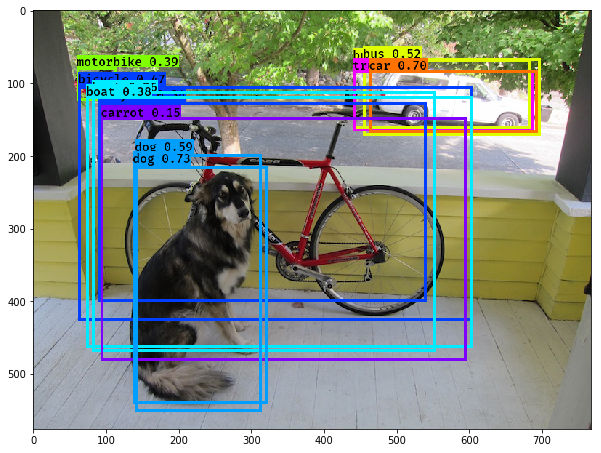

In [47]:
plt.imshow(im_w_boxes)

## Non max supression
You can clearly see that in the image, multiple boxes seem to concern the same object. For example there is two boxes for the dog. We do this through a process called non max supression. Non max supression sorts all predictions by their score. It then removes all predictions whose boxes overlap too much with the boxes of higher scoring predictions. The specific unit by which non max supression defines overlap is the 'intersection over union' or iou:

![IOU](./assets/iou.png)

Out function, implemented after a version of Dr. Tomasz Malisiewicz, returns the indeces of the predictions to keep:

In [48]:
# Malisiewicz et al.
def non_max_suppression_fast(boxes, scores, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []


    # initialize the list of picked indexes	
    pick = []

    # Get bounding box coordinates
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]

    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)

    # Get indices of predictions sorted by their scores
    idxs = np.argsort(scores)

    # We now go through the indexes and kick out the ones with too high iou to better predictions
    # We do this till none of the original indices are left
    while len(idxs) > 0:
        # If an index has not been kicked out because it had too much overlap it must be good so we want to keep it
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # we now calculate the iou:
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap 
        iou = (w * h) / area[idxs[:last]]

        # Remove all predictions that are worse than this one and have an iou higher than the threshold
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(iou > overlapThresh)[0])))

    # return the indexes we want to keep
    return pick

We can now filter our boxes using non max supression. We have to specify which iou we want to accept. 0.5 is a common choice.

In [49]:
iou_threshold = 0.5
nms = non_max_suppression_fast(boxes, scores, iou_threshold)

Now we can render the image with filtered boxes:

dog 0.73 (137, 214) (323, 540)
car 0.70 (462, 82) (694, 168)
bicycle 0.47 (62, 105) (604, 427)
motorbike 0.39 (60, 78) (114, 124)


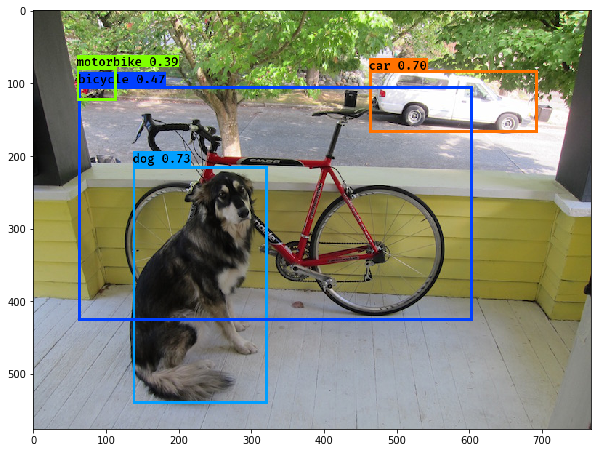

In [50]:
cut_im_w_boxes = draw_boxes(image=image.copy(),
                        boxes=boxes[nms], 
                        box_classes=classes[nms], 
                        class_names=class_names,
                        scores=scores[nms])
plt.imshow(cut_im_w_boxes)

And that is it, we have a nice object detection algorithm now! As mentioned earlier, all operations we defined in this chapter could be seen as part of one computational graph. It woul look something like this:

![YOLO Graph](./assets/yolo_graph.png)

A deep learning library like TensorFlow could take this graph and automatically compute the derivatives along all the operations to optimize the weights used in the conv net (the other modules do not have parameters that get updated). Yolo uses a very smart loss function. Readers who want to dive in a bit deeper should definetly read the original [Yolo paper](https://arxiv.org/abs/1506.02640) as well as the paper describing [Yolo v2](http://arxiv.org/abs/1612.08242).

## Summary
In this chapter, you have seen how to work with Yolo v2 for object detection. You have seen how a computational graph is built and you had the chance to see how a cutting edge deep learning paper translates into a practical implementation.

@article{DBLP:journals/corr/RedmonF16,
  author    = {Joseph Redmon and
               Ali Farhadi},
  title     = {{YOLO9000:} Better, Faster, Stronger},
  journal   = {CoRR},
  volume    = {abs/1612.08242},
  year      = {2016},
  url       = {http://arxiv.org/abs/1612.08242},
  archivePrefix = {arXiv},
  eprint    = {1612.08242},
  timestamp = {Wed, 07 Jun 2017 14:40:20 +0200},
  biburl    = {http://dblp.org/rec/bib/journals/corr/RedmonF16},
  bibsource = {dblp computer science bibliography, http://dblp.org}
}